In [130]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

### Load dataframe with manually set scores

In [131]:
# Get manual scores and merge with dates
manual_polarity = pd.read_csv('Scores/manual_polarity.csv')
manual_polarity.head()

,CleanReportName,ReportName,MyReportName,AverageManualScore,Years
0,FINAL-Q4-17-Shareholder-Letter,COMBINED-Q4-17-Shareholder-Letter-FINAL,COMBINED-Q4-17-Shareholder-Letter-FINAL,0.600000,2017
1,FINAL-Q2-15-Shareholder-Letter,FINAL_Q2_15_Letter_to_Shareholders_With_Tables_,FINAL_Q2_15_Letter_to_Shareholders_With_Tables_,0.333333,2015
2,FINAL-Q3-15-Shareholder-Letter,FINAL_Q3_15_Letter_to_Shareholders_With_Tables_,FINAL_Q3_15_Letter_to_Shareholders_With_Tables_,0.166667,2015
3,FINAL-Q3-16-Shareholder-Letter,FINAL_Q3_Letter,FINAL_Q3_Letter,0.483333,2016
4,FINAL-Q1-18-Shareholder-Letter,FINAL-Q1-18-Shareholder-Letter,FINAL-Q1-18-Shareholder-Letter,0.500000,2018


### Calculate metrics for sentiment models

In [132]:
# get the polarity scores for each model and evaluate them using MAE, MSE, and correlation rate
models_dict = {
    'Baseline Frequency': "Scores/baseline_frequency_polarity.csv",
    'Baseline Keyword': "Scores/baseline_keyword_polarity.csv",
    'BERT': "Scores/bert_polarity.csv",
    "FinBERT": "Scores/finbert_polarity.csv",
    'Roberta': "Scores/roberta_polarity.csv",
    'TextBlob': "Scores/textblob_polarity.csv",
    'Amazon': "Scores/amazon_polarity.csv",
    'Google': "Scores/google_polarity.csv",
    'OpenAI': "Scores/openai_polarity.csv",
}

predictions = {}
years_values = {}

# iterate over the models
for model, path in models_dict.items():

    try:

        # merge predicted and manual polarity scores
        df = pd.read_csv(path)
        df = pd.merge(manual_polarity, df, left_on='MyReportName', right_on="pdf_name", how='left')
        df["polarity"] = pd.to_numeric(df["polarity"])

        # apply min max scaling to the polarity scores
        scaler = MinMaxScaler(feature_range=(df.AverageManualScore.min(), df.AverageManualScore.max()))
        # transform the predicted polarity scores
        df['predicted_scaled_scores'] = scaler.fit_transform(df[['polarity']])
        
        # get the predicted and actual scores
        predicted = df["predicted_scaled_scores"].to_numpy()
        actual = df["AverageManualScore"].to_numpy()
        
        # save the predicted scores
        predictions[model] = predicted

        # get the average polarity score for each model by year
        year_values = df.groupby('Years')['predicted_scaled_scores'].mean()
        years_values[model] = year_values

        # calculate the error metrics
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        corr_rate = np.corrcoef(actual, predicted)[0, 1]

        print(f"{model} Model {df.shape} Results:")
        print(f"Correlation between {model} polarity and manual polarity: ", corr_rate)
        print("MAE:", mae)
        print("MSE:", mse)
        print(" ")

    except:
        
        print(f"{model} failed")
        print(" ")
        print(" ")
        continue

Baseline Frequency Model (50, 8) Results:
Correlation between Baseline Frequency polarity and manual polarity:  0.03700198889930632
MAE: 0.22985990337868403
MSE: 0.07403471901227063
 
Baseline Keyword Model (50, 11) Results:
Correlation between Baseline Keyword polarity and manual polarity:  0.10740811324654208
MAE: 0.23166666666495453
MSE: 0.0726416666653465
 
BERT Model (50, 11) Results:
Correlation between BERT polarity and manual polarity:  0.07354505457257693
MAE: 0.19323449628783596
MSE: 0.06320343313455166
 
FinBERT Model (50, 11) Results:
Correlation between FinBERT polarity and manual polarity:  0.08445958153696455
MAE: 0.1788698740288147
MSE: 0.05625464715113759
 
Roberta Model (50, 11) Results:
Correlation between Roberta polarity and manual polarity:  0.07494542285516889
MAE: 0.1925292053843577
MSE: 0.06273624731490812
 
TextBlob Model (50, 9) Results:
Correlation between TextBlob polarity and manual polarity:  0.1938667056272002
MAE: 0.17062031608790346
MSE: 0.043291568515

### Visualisations

#### Visualisation 1. Correlation matrix of sentiment scores

In [133]:
# get predictions from each model and merge with manual scores
predictions_df = pd.DataFrame(predictions)
predictions_df["AverageManualScore"] = manual_polarity["AverageManualScore"]
predictions_df.head()

,Baseline Frequency,Baseline Keyword,BERT,FinBERT,Roberta,TextBlob,Amazon,Google,OpenAI,AverageManualScore
0,0.065459,0.350000,0.199526,0.399488,0.206080,0.583147,0.650000,0.405556,0.650000,0.600000
1,0.150483,0.150000,0.398344,0.586286,0.405077,0.337562,0.316114,0.405556,0.405556,0.333333
2,0.076087,-0.083333,0.376565,0.431581,0.382757,0.212582,0.175407,0.161111,0.405556,0.166667
3,0.161111,0.283333,0.105269,0.401399,0.118249,0.294884,0.187970,0.405556,0.405556,0.483333
4,-0.051449,-0.016667,0.444919,0.553384,0.449740,0.239324,0.545061,0.405556,0.405556,0.500000


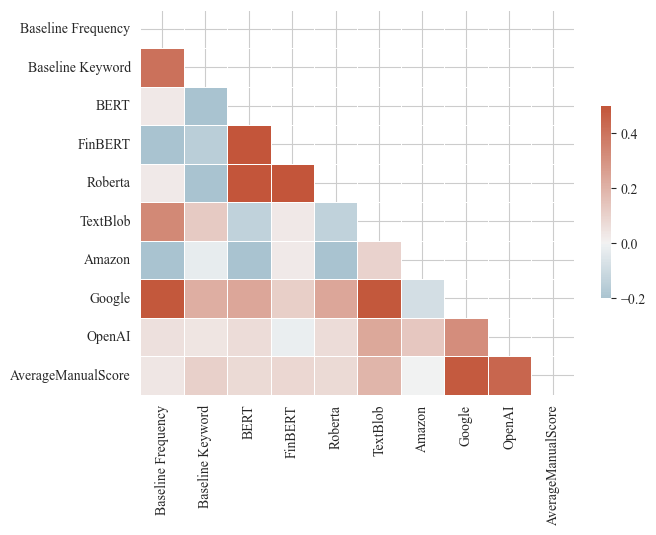

In [134]:
# plot correlation matrix
plt.figure(figsize=(7,5))
plt.rcParams['font.sans-serif'] = 'Times New Roman'
corr = predictions_df.corr()
# creating mask and cmap for correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True) 
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.2, vmax=.5, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### Visualisation 2. Error box plots

In [135]:
# Calculate absolute error for each model
for model in predictions_df.columns[:-1]: # exclude 'AverageManualScore'
    predictions_df[model + '_error'] = abs(predictions_df[model] - predictions_df['AverageManualScore'])

In [136]:
predictions_df.head()

,Baseline Frequency,Baseline Keyword,BERT,FinBERT,Roberta,TextBlob,Amazon,Google,OpenAI,AverageManualScore,Baseline Frequency_error,Baseline Keyword_error,BERT_error,FinBERT_error,Roberta_error,TextBlob_error,Amazon_error,Google_error,OpenAI_error
0,0.065459,0.350000,0.199526,0.399488,0.206080,0.583147,0.650000,0.405556,0.650000,0.600000,0.534541,0.250000,0.400474,0.200512,0.393920,0.016853,0.050000,0.194444,0.050000
1,0.150483,0.150000,0.398344,0.586286,0.405077,0.337562,0.316114,0.405556,0.405556,0.333333,0.182850,0.183333,0.065011,0.252953,0.071743,0.004229,0.017219,0.072222,0.072222
2,0.076087,-0.083333,0.376565,0.431581,0.382757,0.212582,0.175407,0.161111,0.405556,0.166667,0.090580,0.250000,0.209898,0.264914,0.216090,0.045915,0.008741,0.005556,0.238889
3,0.161111,0.283333,0.105269,0.401399,0.118249,0.294884,0.187970,0.405556,0.405556,0.483333,0.322222,0.200000,0.378064,0.081935,0.365085,0.188450,0.295363,0.077778,0.077778
4,-0.051449,-0.016667,0.444919,0.553384,0.449740,0.239324,0.545061,0.405556,0.405556,0.500000,0.551449,0.516667,0.055081,0.053384,0.050260,0.260676,0.045061,0.094444,0.094444


In [113]:
# Melt the dataframe for plotting
predictions_df_melt = predictions_df.melt(id_vars='AverageManualScore', value_vars=list(predictions_df.columns[9:].values))

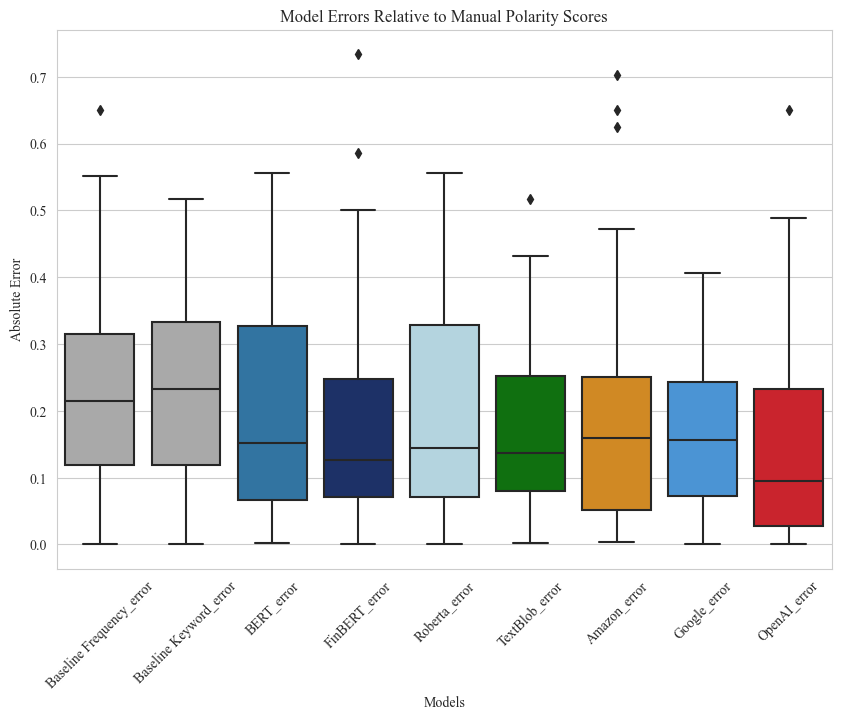

In [137]:
# Plot error box plots for each model

colors = ["darkgray", "darkgray", "#1f77b4", "#112b73", "lightblue", "green", "#EC8E08", "#3495eb", "#E50814"] # Add or modify colors as needed

sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.figure(figsize=(10, 7))
sns.boxplot(x='variable', y='value', data=predictions_df_melt, palette=colors)
plt.xlabel("Models")
plt.ylabel("Absolute Error")
plt.title("Model Errors Relative to Manual Polarity Scores")
plt.xticks(rotation=45)
plt.show()

In [138]:
# export predictions
export_predictions = predictions_df.copy()
export_predictions["ReportName"] = manual_polarity["ReportName"]
# export_predictions.to_csv("Scores/total_predictions.csv", index=False)

In [139]:
export_predictions.head()

,Baseline Frequency,Baseline Keyword,BERT,FinBERT,Roberta,TextBlob,Amazon,Google,OpenAI,AverageManualScore,Baseline Frequency_error,Baseline Keyword_error,BERT_error,FinBERT_error,Roberta_error,TextBlob_error,Amazon_error,Google_error,OpenAI_error,ReportName
0,0.065459,0.350000,0.199526,0.399488,0.206080,0.583147,0.650000,0.405556,0.650000,0.600000,0.534541,0.250000,0.400474,0.200512,0.393920,0.016853,0.050000,0.194444,0.050000,COMBINED-Q4-17-Shareholder-Letter-FINAL
1,0.150483,0.150000,0.398344,0.586286,0.405077,0.337562,0.316114,0.405556,0.405556,0.333333,0.182850,0.183333,0.065011,0.252953,0.071743,0.004229,0.017219,0.072222,0.072222,FINAL_Q2_15_Letter_to_Shareholders_With_Tables_
2,0.076087,-0.083333,0.376565,0.431581,0.382757,0.212582,0.175407,0.161111,0.405556,0.166667,0.090580,0.250000,0.209898,0.264914,0.216090,0.045915,0.008741,0.005556,0.238889,FINAL_Q3_15_Letter_to_Shareholders_With_Tables_
3,0.161111,0.283333,0.105269,0.401399,0.118249,0.294884,0.187970,0.405556,0.405556,0.483333,0.322222,0.200000,0.378064,0.081935,0.365085,0.188450,0.295363,0.077778,0.077778,FINAL_Q3_Letter
4,-0.051449,-0.016667,0.444919,0.553384,0.449740,0.239324,0.545061,0.405556,0.405556,0.500000,0.551449,0.516667,0.055081,0.053384,0.050260,0.260676,0.045061,0.094444,0.094444,FINAL-Q1-18-Shareholder-Letter


#### Majority Voting Approach

In [140]:
total_predictions = pd.read_csv("Scores/total_predictions.csv")
total_predictions.head()

,Baseline Frequency,Baseline Keyword,BERT,FinBERT,Roberta,TextBlob,Amazon,Google,OpenAI,AverageManualScore,Baseline Frequency_error,Baseline Keyword_error,BERT_error,FinBERT_error,Roberta_error,TextBlob_error,Amazon_error,Google_error,OpenAI_error,ReportName
0,0.065459,0.350000,0.199526,0.399488,0.206080,0.583147,0.650000,0.405556,0.650000,0.600000,0.534541,0.250000,0.400474,0.200512,0.393920,0.016853,0.050000,0.194444,0.050000,COMBINED-Q4-17-Shareholder-Letter-FINAL
1,0.150483,0.150000,0.398344,0.586286,0.405077,0.337562,0.316114,0.405556,0.405556,0.333333,0.182850,0.183333,0.065011,0.252953,0.071743,0.004229,0.017219,0.072222,0.072222,FINAL_Q2_15_Letter_to_Shareholders_With_Tables_
2,0.076087,-0.083333,0.376565,0.431581,0.382757,0.212582,0.175407,0.161111,0.405556,0.166667,0.090580,0.250000,0.209898,0.264914,0.216090,0.045915,0.008741,0.005556,0.238889,FINAL_Q3_15_Letter_to_Shareholders_With_Tables_
3,0.161111,0.283333,0.105269,0.401399,0.118249,0.294884,0.187970,0.405556,0.405556,0.483333,0.322222,0.200000,0.378064,0.081935,0.365085,0.188450,0.295363,0.077778,0.077778,FINAL_Q3_Letter
4,-0.051449,-0.016667,0.444919,0.553384,0.449740,0.239324,0.545061,0.405556,0.405556,0.500000,0.551449,0.516667,0.055081,0.053384,0.050260,0.260676,0.045061,0.094444,0.094444,FINAL-Q1-18-Shareholder-Letter


In [141]:
# get model errors
model_errors = {}
for column in export_predictions.columns[17:-1]:
    model_errors[column] = export_predictions[column].mean()
# store model errors in a dataframe
model_errors_df = pd.DataFrame.from_dict(model_errors, orient='index', columns=['Error'])
# calculate weights for each model as the inverse of the model error
model_errors_df['Weight'] = 1 - model_errors_df['Error'] / model_errors_df['Error'].sum()

In [142]:
filtered_errors = model_errors_df
filtered_errors

,Error,Weight
Google_error,0.145222,0.509752
OpenAI_error,0.151000,0.490248


In [143]:
filtered_predictions = total_predictions[total_predictions.columns[7:9]]
filtered_predictions.head()

,Google,OpenAI
0,0.405556,0.650000
1,0.405556,0.405556
2,0.161111,0.405556
3,0.405556,0.405556
4,0.405556,0.405556


In [144]:
# define degree range
degree_range = np.arange(0, 1000, 1)
# set default value for MAE
min_mae = 1

for degree in tqdm(degree_range):
    # Get weighted average predictions
    weighted_average_predictions = np.average(filtered_predictions, axis=1, weights=filtered_errors['Weight'].values**degree)
    # Calculate error metrics
    mae = mean_absolute_error(actual, weighted_average_predictions)
    mse = mean_squared_error(actual, weighted_average_predictions)
    if mae < min_mae:
        min_mae = mae
        min_mse = mse
        best_degree = degree
        best_weighted_average_predictions = weighted_average_predictions

print("Best degree:", best_degree)
print("Min MAE:", min_mae)
print("Min MSE:", min_mse)

  0%|          | 0/1000 [00:00<?, ?it/s]

Best degree: 0
Min MAE: 0.11455555610154254
Min MSE: 0.024030555374968947


In [145]:
# print best weights
best_weights = filtered_errors['Weight'].values**best_degree
print("Best weights:", best_weights)

Best weights: [1. 1.]


#### Visualisation 3. Multiple line plot showing sentiment scores over time

In [146]:
years_manual_df = manual_polarity.groupby('Years')['AverageManualScore'].mean().reset_index()

In [147]:
years_values_df = pd.DataFrame(years_values).reset_index()
years_values_df.head()

,Years,Baseline Frequency,Baseline Keyword,BERT,FinBERT,Roberta,TextBlob,Amazon,Google,OpenAI
0,2011,0.179710,0.183333,0.481441,0.469443,0.483353,0.218300,0.286555,0.161111,0.283333
1,2012,0.557005,0.333333,0.470146,0.371329,0.473118,0.289707,0.199389,0.405556,0.405556
2,2013,0.267391,0.125000,0.555316,0.436827,0.555597,0.353429,0.438165,0.527778,0.650000
3,2014,0.299275,0.150000,0.506274,0.542100,0.505760,0.349766,0.251685,0.405556,0.344444
4,2015,0.126570,0.050000,0.401636,0.463585,0.405363,0.219651,0.225311,0.222222,0.344444


In [148]:
# merge the average yearly polarity scores for each model with the average yearly manual scores
years_values_df = pd.merge(years_values_df, years_manual_df, left_on='Years', right_on="Years", how='inner')
years_values_df.rename(columns={'AverageManualScore': 'Benchmark'}, inplace=True)

In [149]:
# merge the average yearly polarity scores for each model with the weighted predictions 
weighted_predictions_df = pd.DataFrame(best_weighted_average_predictions, columns=['Weighted Average Predictions'])
weighted_predictions_df['Years'] = manual_polarity['Years']
weighted_predictions_df = weighted_predictions_df.groupby('Years')['Weighted Average Predictions'].mean().reset_index()
years_values_df = pd.merge(years_values_df, weighted_predictions_df, left_on='Years', right_on="Years", how='inner')

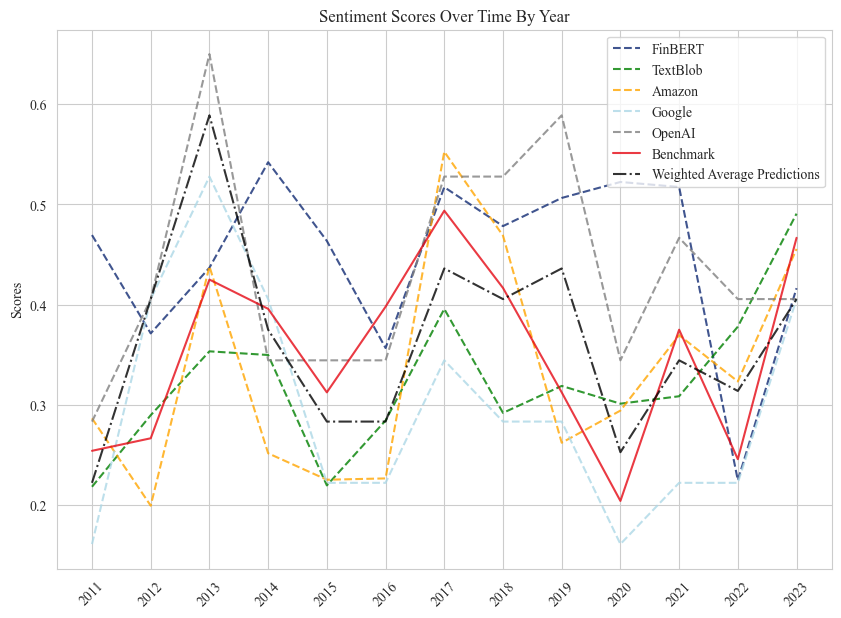

In [150]:
# plot average manual polarity scores over time
plt.figure(figsize=(10, 7))

colors = {
    'FinBERT': '#112b73',
    'TextBlob': 'green',
    'Amazon': 'orange',
    'Google': 'lightblue',
    'OpenAI': 'grey',
    'Benchmark': '#E50914',
    'Weighted Average Predictions': 'black'
}

line_styles = {
    'FinBERT': '--',
    'TextBlob': '--',
    'Amazon': '--',
    'Google': '--',
    'OpenAI': '--',
    'Benchmark': '-',
    'Weighted Average Predictions': '-.',
}
# iterate over the models and plot the average polarity scores
for model in list(years_values_df.columns[1:]):
    if model in colors.keys():
        sns.lineplot(x='Years', y=model, data=years_values_df, label=model, alpha=0.8, color=colors[model], dashes=True, linestyle=line_styles[model])
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.xlabel("").set_visible(False)
plt.ylabel("Scores")
plt.title("Sentiment Scores Over Time By Year")
plt.xticks(np.arange(min(years_values_df['Years']), max(years_values_df['Years']) + 1, 1), rotation=45)
plt.legend(loc='upper right')
plt.show()

In [62]:
# export the average polarity scores for each model by year
# years_values_df.to_csv("Scores/years_predictions.csv", index=False)

### Post Market Judgment

In [151]:
# Load the post market polarity scores
post_market_polarity = pd.read_csv("Scores/postmarket_openai.csv")
# Group by report name and get the average polarity score
post_market_polarity = post_market_polarity[["CleanReport", "score"]].groupby("CleanReport").mean().reset_index()
# Merge with manual scores
post_market_polarity = pd.merge(post_market_polarity, manual_polarity, left_on='CleanReport', right_on="CleanReportName", how='inner')
post_market_polarity.shape

(19, 7)

In [152]:
# Convert polarity scores to numeric format
post_market_polarity["score"] = pd.to_numeric(post_market_polarity["score"])

# Calculate the correlation rate
corr_rate_postmarket = post_market_polarity["score"].corr(post_market_polarity["AverageManualScore"])

# apply min max scaling to the polarity scores
scaler = MinMaxScaler(feature_range=(post_market_polarity.AverageManualScore.min(), post_market_polarity.AverageManualScore.max()))
post_market_polarity['score_scaled'] = scaler.fit_transform(post_market_polarity[['score']])

# Calculate the error metrics
predicted_post_market = post_market_polarity["score_scaled"]
actual_post_market = post_market_polarity["AverageManualScore"]
mae = mean_absolute_error(actual_post_market, predicted_post_market)
mse = mean_squared_error(actual_post_market, predicted_post_market)

print("Post Market's Results:")
print(f"Correlation between Post Market polarity and manual polarity: ", corr_rate_postmarket)
print("MAE:", mae)
print("MSE:", mse)

Post Market's Results:
Correlation between Post Market polarity and manual polarity:  0.40959620442602995
MAE: 0.16064786968218872
MSE: 0.04973931582359994
